In [1]:
import polars as pl
import tempfile
import zipfile
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from matplotlib.colors import TwoSlopeNorm
import math

# Load the india grid
with tempfile.TemporaryDirectory() as tmpdir:
    zip_path = Path("../../grid_india_10km_shapefiles.zip")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(tmpdir)
        grid_path = Path(tmpdir, "grid_india_10km", "grid_india_10km.shp")
        
        grid = gpd.read_file(grid_path)
        # Convert grid_id to int and then to string
        grid["grid_id"] = grid["grid_id"].astype(int).astype(str)


In [2]:
expected = pl.read_parquet(
    "inputs/expected_imputation_2023_01"
)

# Convert date to string "YYYY-MM-DD"
expected = expected.with_columns(
    pl.col("date").dt.strftime("%Y-%m-%d").alias("date"),
)

actual = pl.read_parquet(
    "gs://crea-pm25ml-combined/stage=combined_monthly/month=2023-01/data.parquet"
)

# Join expected and actual dataframes on 'date' and 'grid_id'
joined = (
    expected
        .join(
            actual,
            on=["date", "grid_id"],
            how="full",
            suffix="_actual",
        )
        .sort(["grid_id", "date"])
        .with_columns(
            pl.col("date").str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("date")
        )
)

In [3]:
# Convert joined to pandas
joined_pd = joined.to_pandas()
grid = grid.copy()
grid.reset_index(inplace=True)
# Set grid_id as index
joined_pd["grid_id"] = joined_pd["grid_id"].astype(int)
grid["grid_id"] = grid["grid_id"].astype(int)
joined_pd.set_index("grid_id", inplace=True)
grid.set_index("grid_id", inplace=True)

# Join to the grid by grid_id
joined_gdf = grid.join(
    joined_pd,
    on="grid_id",
    how="left",
)
joined_gdf = joined_gdf.to_crs("EPSG:4326")  # Convert to WGS84

In [4]:
india_gdf = joined_gdf.to_crs(epsg=7755)

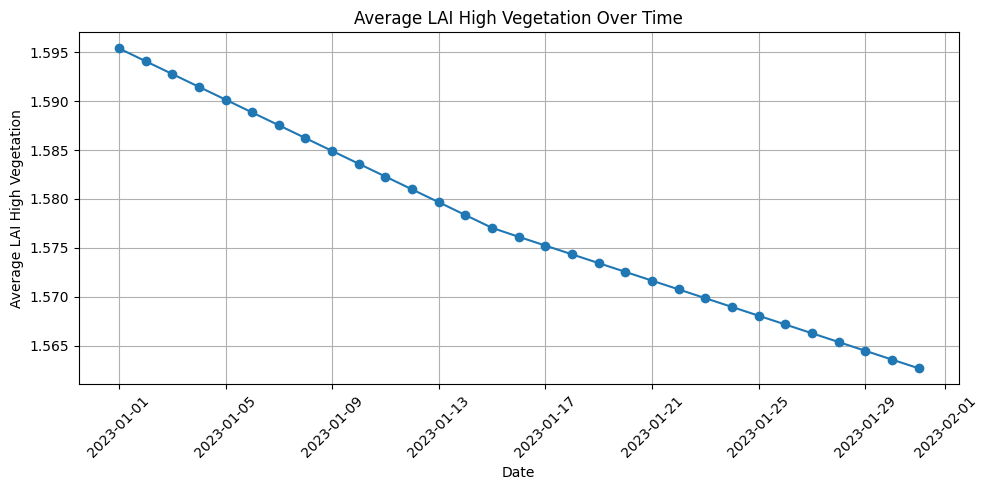

In [5]:
# What does the average era5_land__leaf_area_index_high_vegetation look like over time?

lai_high_over_time = joined.group_by("date").agg(
    pl.col("era5_land__leaf_area_index_high_vegetation").mean().alias("lai_high_over_time")
).sort("date")

# Plot the average LAI over time
plt.figure(figsize=(10, 5))
plt.plot(
    lai_high_over_time["date"].to_numpy(),
    lai_high_over_time["lai_high_over_time"].to_numpy(),
    marker='o',
    linestyle='-'
)
plt.title("Average LAI High Vegetation Over Time")
plt.xlabel("Date")
plt.ylabel("Average LAI High Vegetation")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

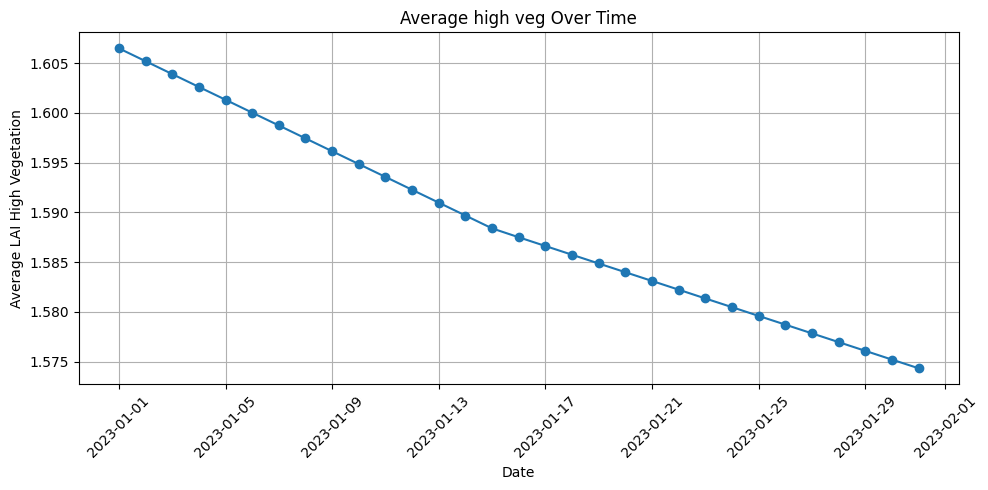

In [6]:
# What does the average era5_land__leaf_area_index_high_vegetation look like over time?

high_veg_over_time = joined.group_by("date").agg(
    pl.col("high_veg").mean().alias("high_veg_over_time")
).sort("date")

# Plot the average LAI over time
plt.figure(figsize=(10, 5))
plt.plot(
    high_veg_over_time["date"].to_numpy(),
    high_veg_over_time["high_veg_over_time"].to_numpy(),
    marker='o',
    linestyle='-'
)
plt.title("Average high veg Over Time")
plt.xlabel("Date")
plt.ylabel("Average LAI High Vegetation")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [7]:
# Plot the average "high_veg" and "era_5_land__leaf_area_index_high_vegetation" on a map

monthly_avg = gpd.GeoDataFrame(
    india_gdf
        # For a fair comparison, we want to filter out the dates that would fall outside the
        # moving average window for omi_no2__no2_rolling_mean
        [(india_gdf["date"] >= "2023-01-04") & (india_gdf["date"] < "2023-02-25")]
        .drop(columns=["date", "date_actual", "index"])
        .groupby(['grid_id', 'geometry'])
        .mean()
        .reset_index()
)


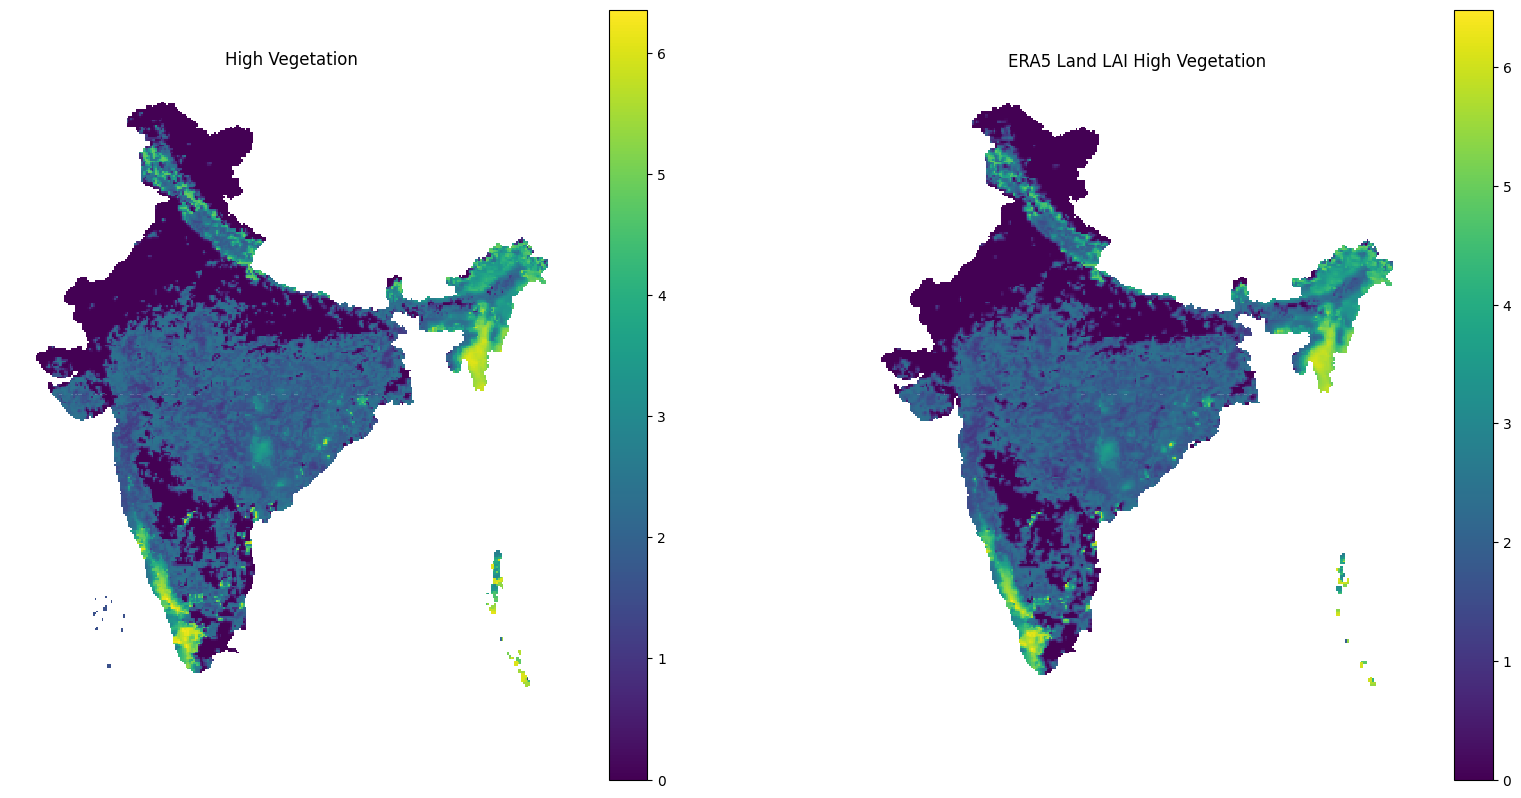

In [8]:

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot high_veg

monthly_avg.plot(
    column="high_veg",
    ax=ax[0],
    legend=True,
    cmap="viridis"
)
ax[0].set_title("High Vegetation")
ax[0].set_axis_off()

# Plot era5_land__leaf_area_index_high_vegetation
monthly_avg.plot(
    column="era5_land__leaf_area_index_high_vegetation",
    ax=ax[1],
    legend=True,
    cmap="viridis"
)
ax[1].set_title("ERA5 Land LAI High Vegetation")
ax[1].set_axis_off()

In [9]:
monthly_avg

,grid_id,geometry,aot_daily,co_daily,omi_no2,v_wind,u_wind,rainfall,temp,pressure,...,omi_no2_v4__no2_trop,omi_no2_v4__no2_trop_cloud_screened,modis_land_cover__forest,modis_land_cover__shrub,modis_land_cover__savanna,modis_land_cover__urban,modis_land_cover__water,srtm_elevation__elevation,grid__lon,grid__lat
0,1278,"POLYGON ((5551162.515 2171391.914, 5551162.515...",0.164845,3.447610e-09,2.371878e+15,-1.710936,-5.043484,0.004516,299.620831,100436.966638,...,5.352763e+14,5.944052e+14,0.000000,0.000000,0.0,0.0,0.990319,0.169749,93.762344,6.748582
1,1279,"POLYGON ((5561162.515 2171391.914, 5561162.515...",0.164845,3.447610e-09,2.371878e+15,-1.711294,-5.045098,0.004535,299.615533,100428.419595,...,4.502341e+14,5.253037e+14,0.048767,0.000000,0.0,0.0,0.873591,4.243562,93.850212,6.739947
2,1607,"POLYGON ((5551162.515 2181391.914, 5551162.515...",0.164845,3.447610e-09,2.371878e+15,-1.709865,-5.038641,0.004461,299.636725,100462.607767,...,4.740733e+14,6.221053e+14,0.134578,0.000000,0.0,0.0,0.744441,11.066980,93.770958,6.836448
3,1608,"POLYGON ((5561162.515 2181391.914, 5561162.515...",0.164845,3.447610e-09,2.371878e+15,-1.712008,-5.048327,0.004572,299.604936,100411.325509,...,4.025219e+14,5.717092e+14,0.582996,0.000000,0.0,0.0,0.207464,46.862236,93.858887,6.827804
4,1609,"POLYGON ((5571162.515 2181391.914, 5571162.515...",0.164845,3.447610e-09,2.330854e+15,-1.712008,-5.048327,0.004572,299.604936,100411.325509,...,3.997032e+14,3.004996e+14,0.000798,0.000000,0.0,0.0,0.985842,0.677799,93.946800,6.819105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33069,108333,"POLYGON ((3561162.515 5431391.914, 3561162.515...",0.089960,3.126398e-09,2.738229e+15,0.720383,0.112783,0.001509,248.410520,55046.869625,...,2.370939e+14,1.968699e+14,0.000000,0.000000,0.0,0.0,0.000000,5133.882324,75.158684,37.028534
33070,108334,"POLYGON ((3571162.515 5431391.914, 3571162.515...",0.089960,3.126398e-09,2.694346e+15,1.249088,0.137767,0.001204,248.423645,54186.937263,...,2.402650e+14,1.945100e+14,0.000000,0.002155,0.0,0.0,0.000000,4970.604004,75.270195,37.031574
33071,108335,"POLYGON ((3581162.515 5431391.914, 3581162.515...",0.089960,3.126398e-09,2.694346e+15,1.339862,0.383280,0.001095,250.559653,56780.829534,...,2.426032e+14,1.923681e+14,0.000000,0.015207,0.0,0.0,0.000000,4646.122559,75.381706,37.034538
33072,108657,"POLYGON ((3511162.515 5441391.914, 3511162.515...",0.091256,3.132268e-09,2.794209e+15,0.852340,-0.078336,0.001640,247.078328,54913.923149,...,1.700324e+14,1.530841e+14,0.000000,0.008572,0.0,0.0,0.000000,4921.124023,74.596962,37.101662


Text(0.5, 1.0, 'Difference between ERA5 LAI and High Vegetation')

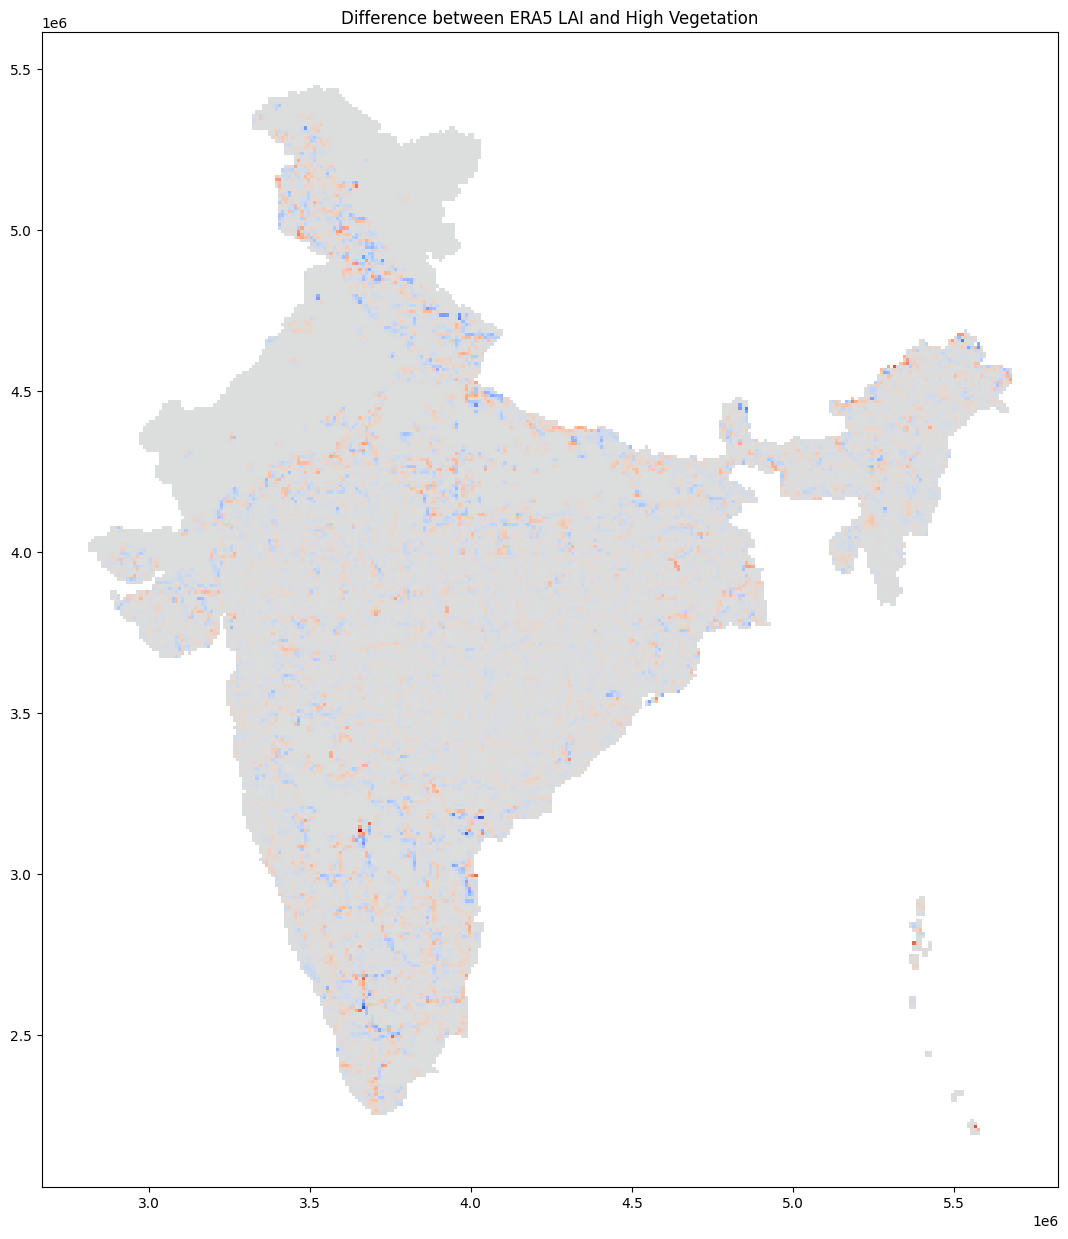

In [10]:
# Plot the difference between the two
monthly_avg["lai_diff"] = monthly_avg["era5_land__leaf_area_index_high_vegetation"] - monthly_avg["high_veg"]
monthly_avg.plot(
    figsize=(30, 15),
    column="lai_diff",
    legend=False,
    cmap="coolwarm",
)
plt.title("Difference between ERA5 LAI and High Vegetation")


Text(0.5, 1.0, 'High Vegetation')

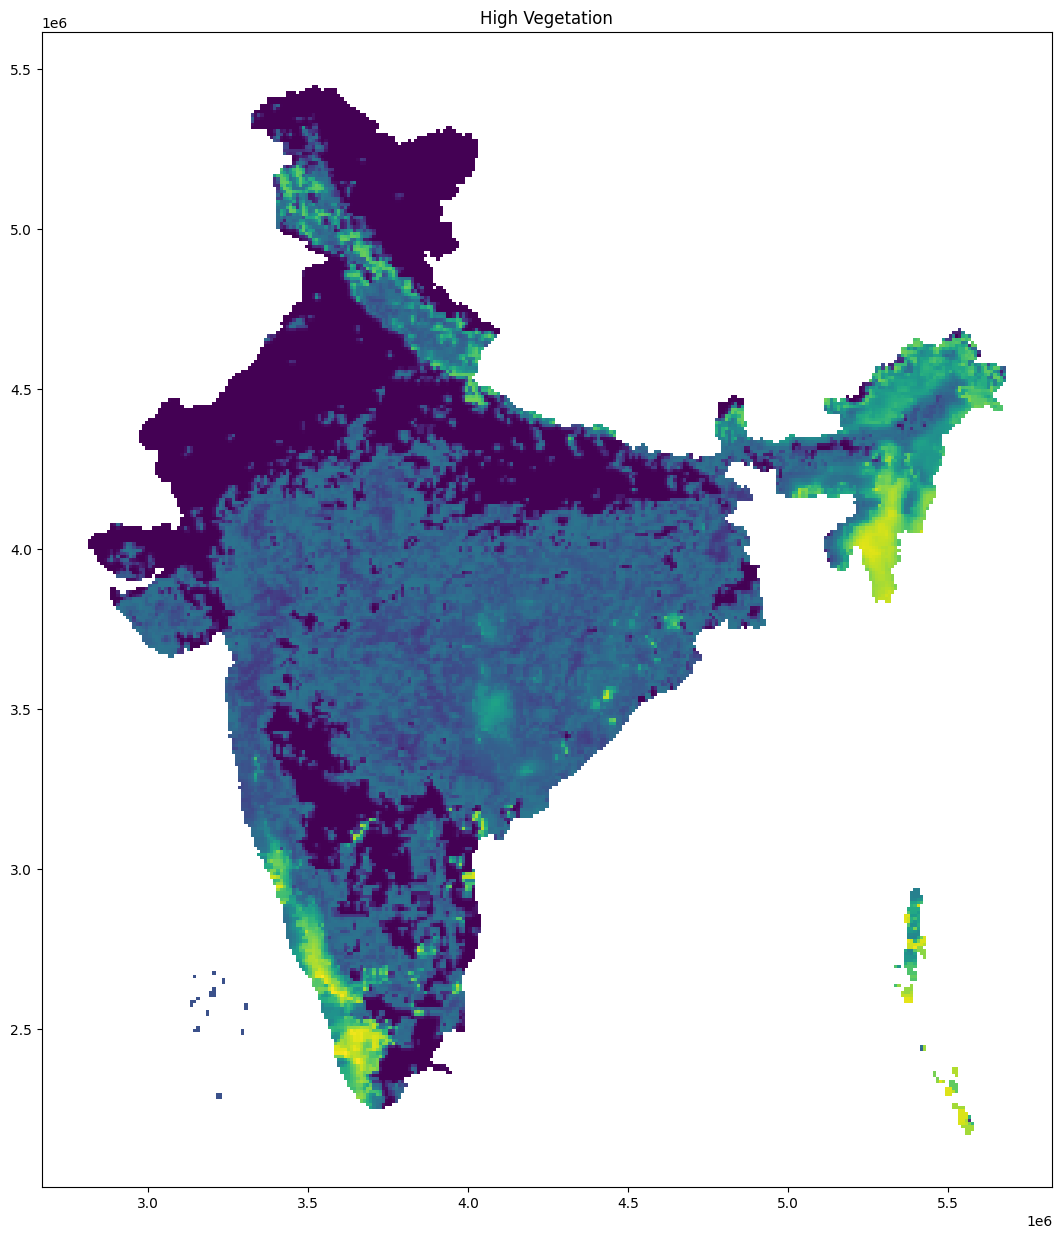

In [11]:
monthly_avg.plot(
    figsize=(30, 15),
    column="high_veg",
    legend=False,
    cmap="viridis",
)
plt.title("High Vegetation")


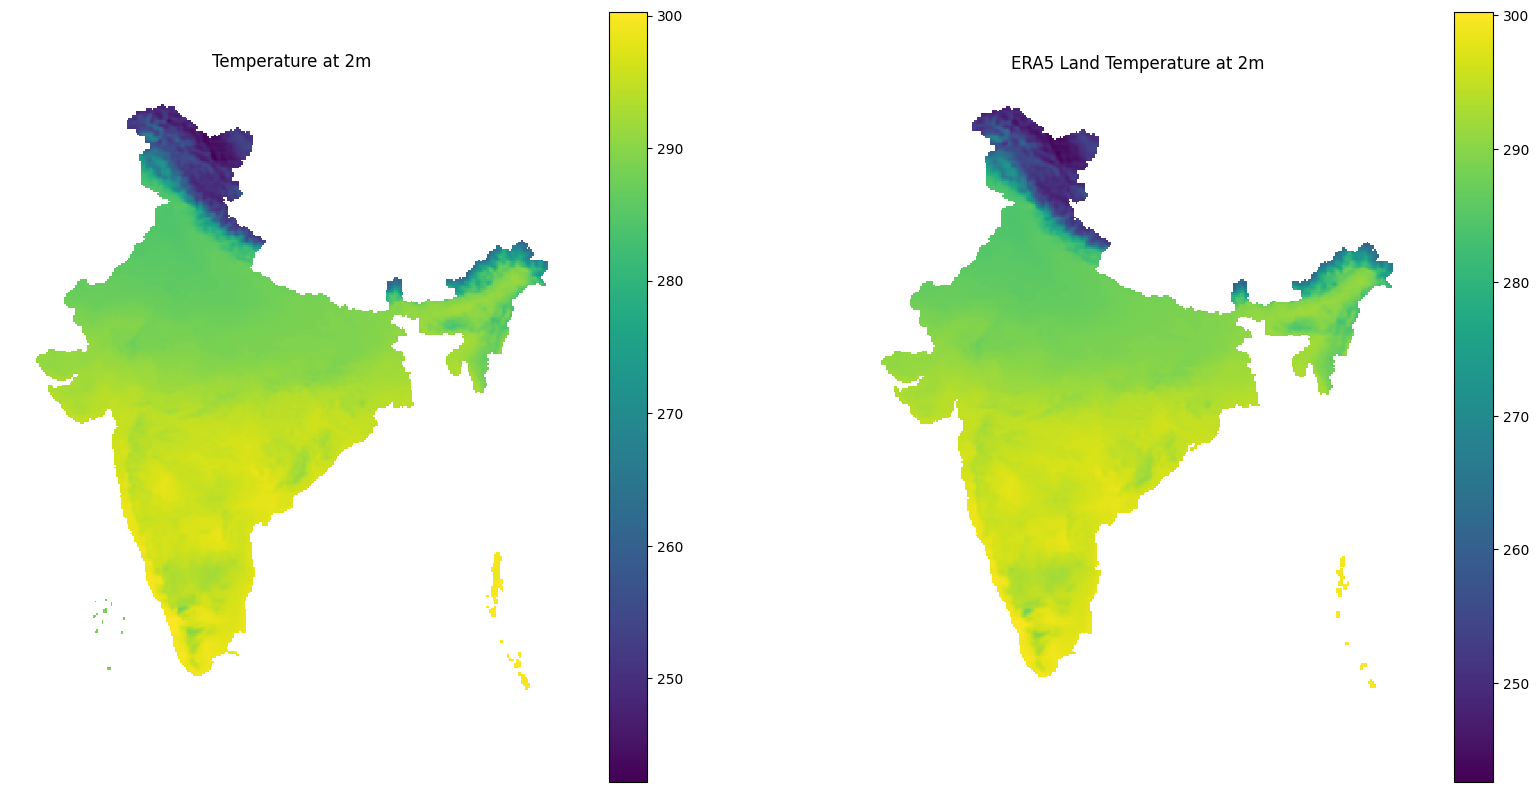

In [12]:

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot high_veg

monthly_avg.plot(
    column="temp",
    ax=ax[0],
    legend=True,
    cmap="viridis"
)
ax[0].set_title("Temperature at 2m")
ax[0].set_axis_off()

# Plot era5_land__leaf_area_index_high_vegetation
monthly_avg.plot(
    column="era5_land__temperature_2m",
    ax=ax[1],
    legend=True,
    cmap="viridis"
)
ax[1].set_title("ERA5 Land Temperature at 2m")
ax[1].set_axis_off()

Text(0.5, 1.0, "Difference between Ayako's Temperature and our Temperature")

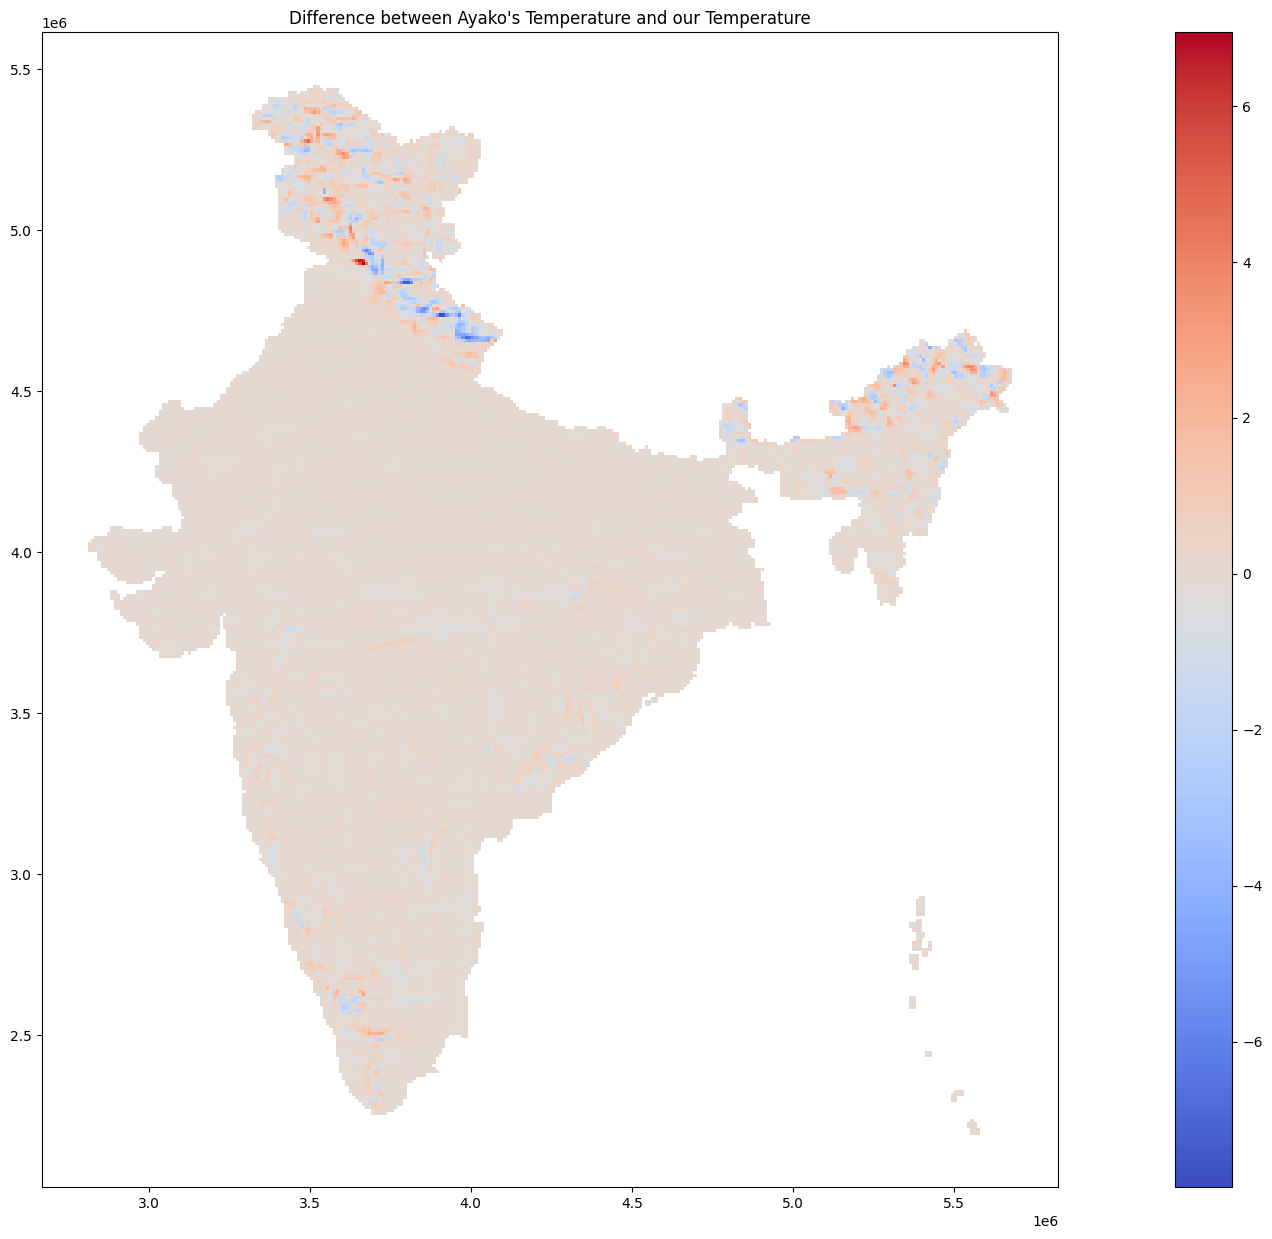

In [13]:
# Plot the difference between the two
monthly_avg["temp_diff"] = monthly_avg["era5_land__temperature_2m"] - monthly_avg["temp"]
monthly_avg.plot(
    figsize=(30, 15),
    column="temp_diff",
    legend=True,
    cmap="coolwarm",
)
plt.title("Difference between Ayako's Temperature and our Temperature")
